## GNN Explainer

Here we visualize the explainer results and analyze specific graph theoretic properties for datatset `syn1`

In [1]:
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
logdir = '../log/'
# Here all the required .npy files are directly under log
expdir = ''

In [3]:
# Load produced masks
dirs = os.listdir(os.path.join(logdir, expdir))
dirs

['enron_base_h20_o20',
 'grad',
 'graph',
 'mask',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_400graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_405graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_410graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_415graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_420graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_425graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_430graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_435graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_440graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_445graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_450graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_455graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_460graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_465gr

In [4]:
masks = []

# This would print all the files and directories
for file in dirs:
    # Check if file extension is ".npy" which are
    # numpy binary files to represent large data
    if file.split('.')[-1] == 'npy' and file.split('_')[2] == 'syn1':
        # print(file)
        masks.append(file)
len(masks)

60

In [5]:
def show_adjacency_full(mask, ax=None):
    """Plot full adjacency matrix of the mask

    Args:
        mask (str): Filename containing the adjacency matrix of the mask
        ax (Axes class object, optional): Axis. Defaults to None.

    Returns:
        numpy matrix: Full adjacency matrix of the mask
    """
    # Obtain adjacency matrix from the filename sent in var "mask"
    adj = np.load(os.path.join(logdir, expdir, mask), allow_pickle=True)
    # if ax is None:
    #     plt.figure()
    #     plt.imshow(adj);
    # else:
    #     ax.imshow(adj)
    return adj

In [6]:
def filter_adj(adj,threshold=0.8):
    """Filter out the values in adjacency matrix that are greater than threshold. Fix the others as 0

    Args:
        adj (numpy matrix): Adjacency matrix of mask that we have to filter
        threshold (float): Filter value

    Returns:
        numpy matrix: Filtered adjacency matrix
    """
    filt_adj = adj.copy()
    filt_adj[adj<threshold] = 0
    return filt_adj

### Analyzing Graph theoretic properties of each mask

Here we measure the following quantities:
- Nodes: |V|
- Edges: |E|
- Avg degree
- Diameter of the graph
- Sparsity measure: edge density = |E|/C(|V|,2)
- Node centrality measure: Betweenness centrality

In [7]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def normalize(A):
    scale_factor = A.max() - A.min()
    B = np.ones_like(A)*A.min()

    A = (A - B)/scale_factor
    return A

def centrality(adj):
    # Get the unweighted adjacency matrix
    adj1 = adj.copy()
    adj1[adj>0] = 1

    # Get the unweighted graph
    unweighted_G = nx.from_numpy_matrix(np.matrix(adj1))

    # For now we use edge-path centrality later check
    # Information centrality metric
    ebc = nx.edge_betweenness_centrality(unweighted_G)

    # Create a symmetric matrix A with A[i][j] is the betweeness score of edge (i,j)
    A = np.zeros_like(adj1)
    v = unweighted_G.number_of_nodes()
    for i in range(v):
        for j in range(i):
            if (j,i) in ebc.keys():
                # The keys in ebc are (a,b) with a < b
                A[i][j] = A[j][i] = ebc[(j,i)]
    
    # Now that we have got A, we see if the importance given by GNNExplainer
    # has some relation with the centrality scores in A
    A1 = normalize(A)
    B1 = normalize(adj)

    # For coherence check the following two links:
    # 1) https://www.geeksforgeeks.org/cosine-similarity-calculation-between-two-matrices-in-matlab/
    # 2) https://math.stackexchange.com/questions/507742/distance-similarity-between-two-matrices#:~:text=If%20we%20have%20two%20matrices,squares%20of%20all%20singular%20values.
    coherence = 1/(np.linalg.norm(A1 - B1,2))**2

    return coherence

def graph_prop(adj):
    # Edge weighted graph
    weighted_G = nx.from_numpy_matrix(np.matrix(adj))

    v = weighted_G.number_of_nodes()
    e = weighted_G.number_of_edges()
    avg_degree = float('%.3f'%(2*e/v))
    diameter = nx.diameter(weighted_G)
    sparsity = float('%.3f'%(2*e/(v*(v-1))))
    coherence_int = float('%.3f'%(centrality(adj)))

    return [v,e,avg_degree,diameter,sparsity,coherence_int]

In [8]:
data = []

for m in masks:
    # Full adjacency matrix
    adj = show_adjacency_full(m)
    # Get the metrics of each mask
    data.append(graph_prop(adj))

In [9]:
import pandas as pd

# Convert the above data into a data frame
df = pd.DataFrame(data, columns=["Order","Size","Average Degree","Diameter","Sparsity","Coherence"])

# # Normalizing coherence
# coh_int = list(df["Coherence"])
# coh = [float(i)/max(coh_int) for i in coh_int]

# df = df.replace(coh_int, coh)


df.describe()

,Order,Size,Average Degree,Diameter,Sparsity,Coherence
count,60.00000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,110.25000,364.983333,6.424917,5.150000,0.060533,0.466900
std,26.79908,134.820218,0.929395,0.360085,0.008001,0.051238
min,62.00000,129.000000,4.161000,5.000000,0.045000,0.240000
25%,89.00000,259.750000,5.834000,5.000000,0.054000,0.458500
50%,107.00000,345.000000,6.451500,5.000000,0.060500,0.476000
75%,129.50000,443.250000,7.089500,5.000000,0.066000,0.488000
max,178.00000,742.000000,8.337000,6.000000,0.077000,0.558000


In [10]:
# Normalize the Coherence
coh_int = list(df["Coherence"])
coh = [float(i)/max(coh_int) for i in coh_int]

df = df.replace(coh_int, coh)
df.describe()

,Order,Size,Average Degree,Diameter,Sparsity,Coherence
count,60.00000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,110.25000,364.983333,6.424917,5.150000,0.060533,0.836738
std,26.79908,134.820218,0.929395,0.360085,0.008001,0.091824
min,62.00000,129.000000,4.161000,5.000000,0.045000,0.430108
25%,89.00000,259.750000,5.834000,5.000000,0.054000,0.821685
50%,107.00000,345.000000,6.451500,5.000000,0.060500,0.853047
75%,129.50000,443.250000,7.089500,5.000000,0.066000,0.874552
max,178.00000,742.000000,8.337000,6.000000,0.077000,1.000000


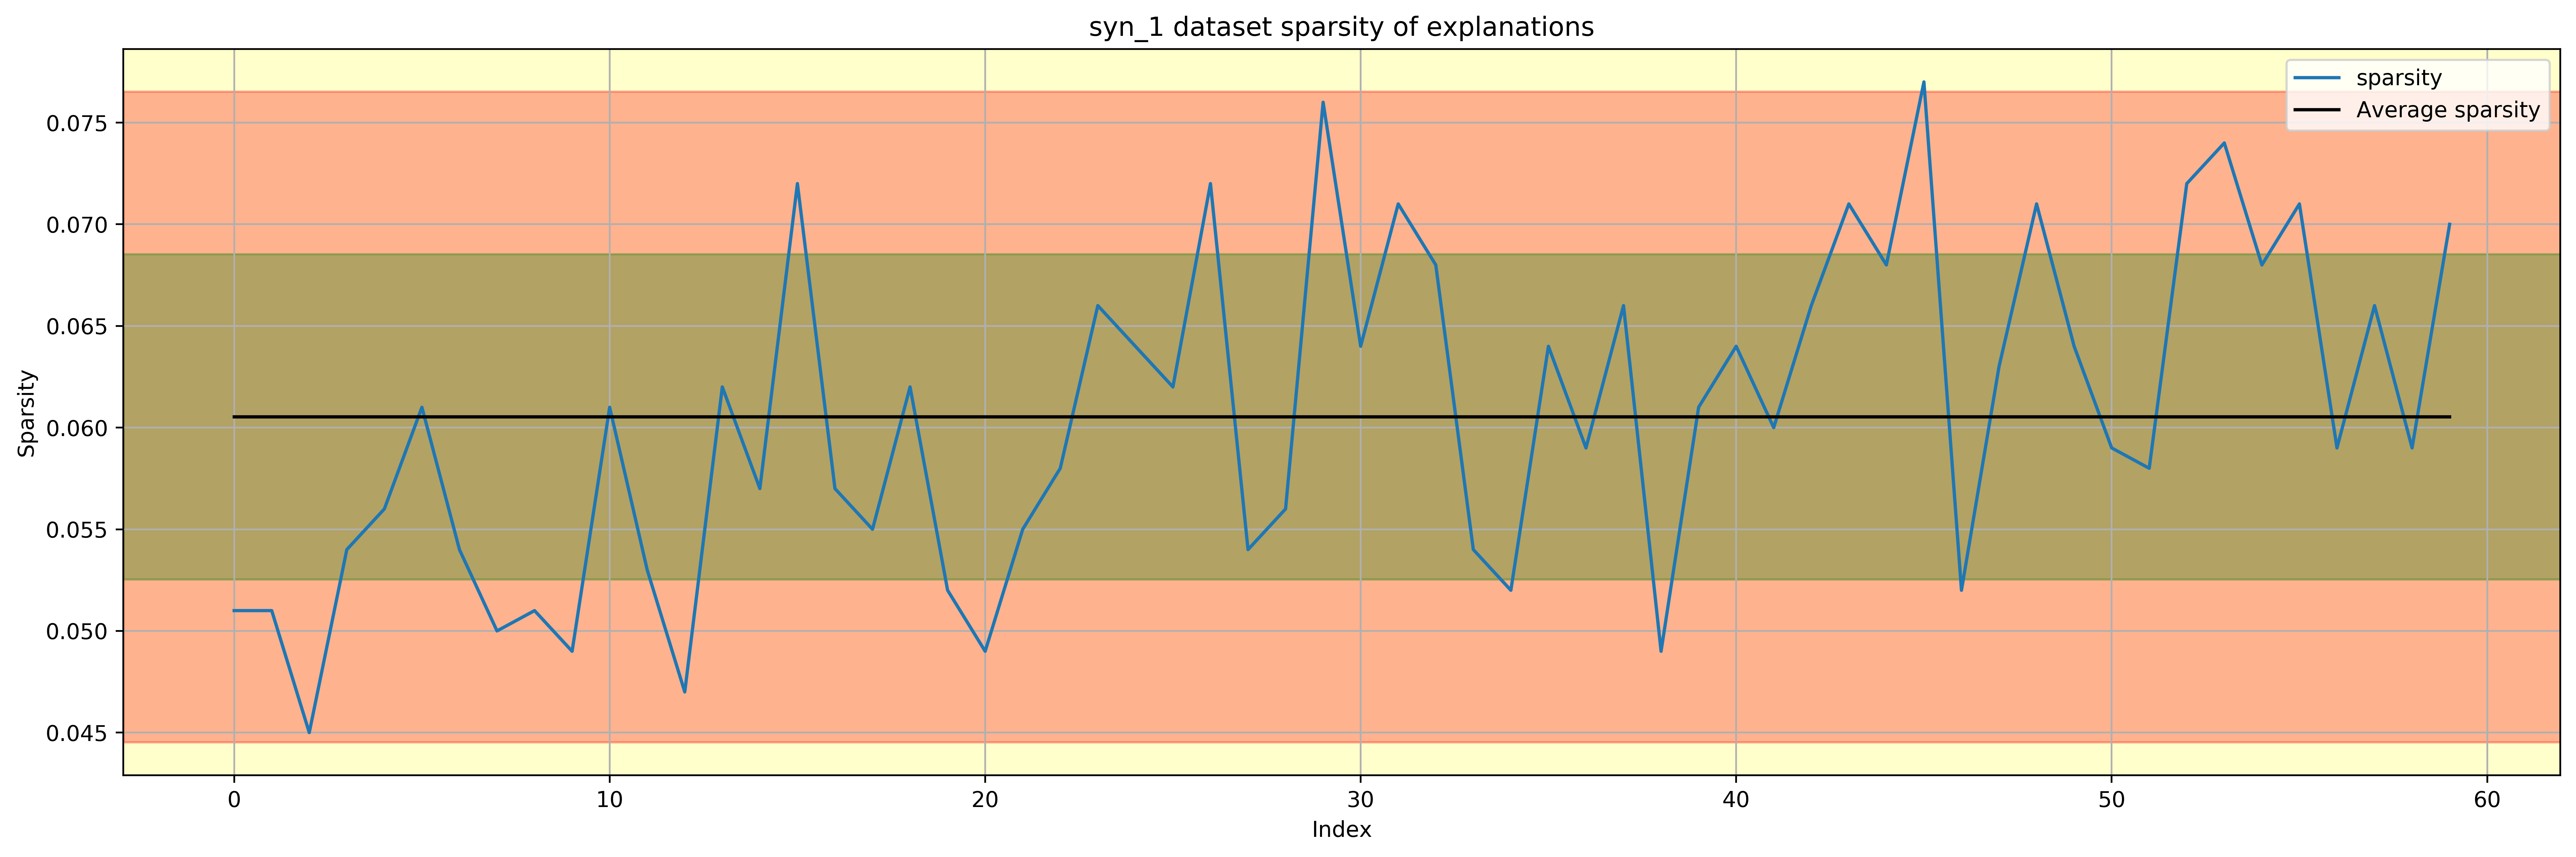

In [29]:
# Plot Sparsity
x = list(range(len(df)))
sparse = list(df['Sparsity'])
def_sparse = list(np.ones(len(df))*0.5)
mean_sparse = list(np.ones(len(df))*df['Sparsity'].mean())
plt.figure(figsize=(20,6), dpi = 500)
plt.gca().grid(True)
plt.gca().set_facecolor((1, 1, 0.8))
plt.plot(x, sparse, label='sparsity')
# plt.plot(x,def_sparse, label = 'Max edge density for sparse graphs')
plt.plot(x,mean_sparse, label = 'Average sparsity', color='k')

sp_mean = df['Sparsity'].mean()
sp_std = df['Sparsity'].std()
y1 = sp_mean - sp_std
y_1 = y1 - sp_std
y2 = sp_mean + sp_std
y_2 = y2 + sp_std
plt.axhspan(y_1, y_2, color='red', alpha=0.3)
plt.axhspan(y1, y2, color='green', alpha=0.3)

plt.title('syn_1 dataset sparsity of explanations', fontsize=12)
plt.legend(prop={'size':10})
plt.ylabel("Sparsity")
plt.xlabel("Index")
plt.savefig(fname= "D:\D_Drive\Github\Thesis\GNNExplainer_graph_properties\graph_theoretic_properties\syn1_sparsity")
plt.show()

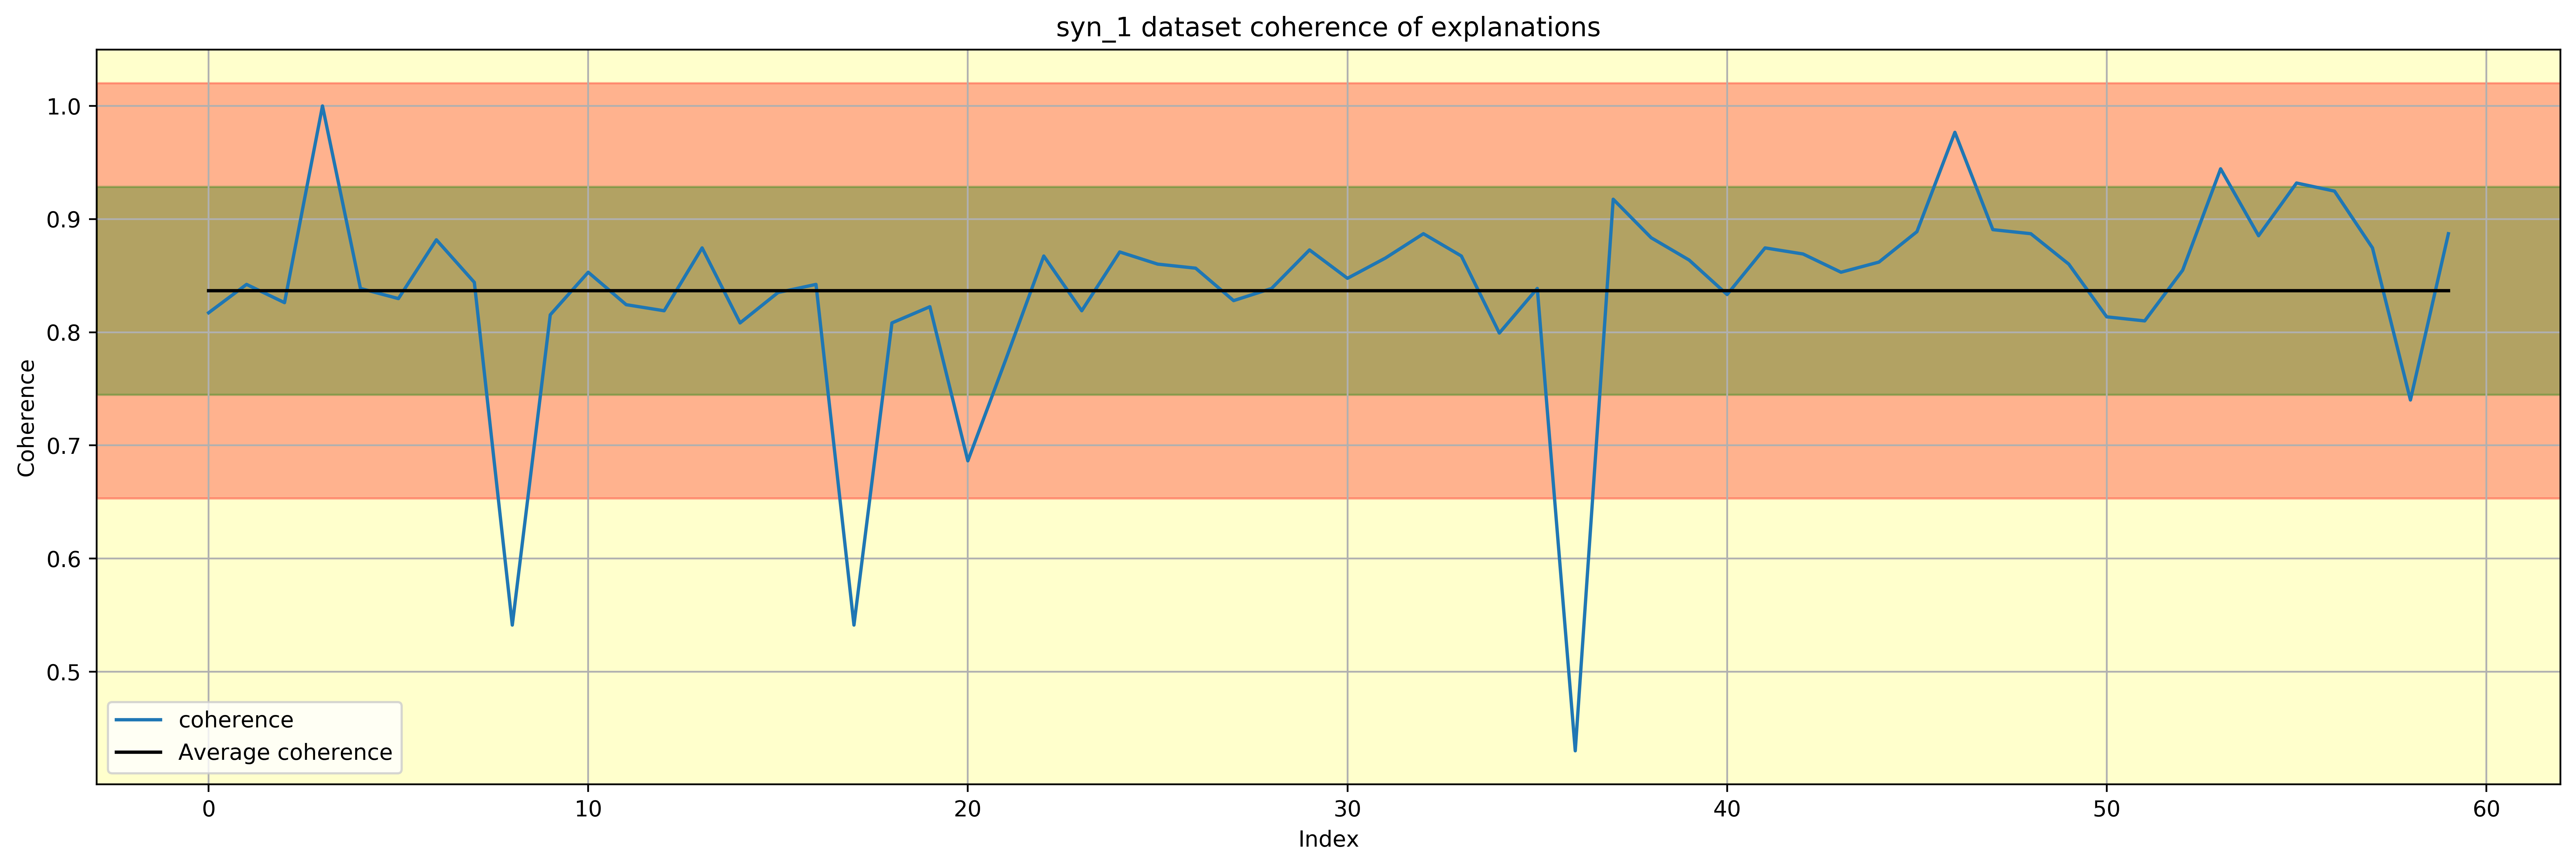

In [30]:
# Plot Coherence
coh = list(df['Coherence'])
mean_coh = list(np.ones(len(df))*df['Coherence'].mean())
plt.figure(figsize=(20,6), dpi = 500)
plt.gca().grid(True)
plt.gca().set_facecolor((1, 1, 0.8))
plt.plot(x, coh, label='coherence')
plt.plot(x,mean_coh, label = 'Average coherence', color='k')

coh_mean = df['Coherence'].mean()
coh_std = df['Coherence'].std()
y1 = coh_mean - coh_std
y_1 = y1 - coh_std
y2 = coh_mean + coh_std
y_2 = y2 + coh_std
plt.axhspan(y_1, y_2, color='red', alpha=0.3)
plt.axhspan(y1, y2, color='green', alpha=0.3)

plt.title('syn_1 dataset coherence of explanations', fontsize=12)
plt.legend(prop={'size':10})
plt.ylabel("Coherence")
plt.xlabel("Index")
plt.savefig(fname= "D:\D_Drive\Github\Thesis\GNNExplainer_graph_properties\graph_theoretic_properties\syn1_coherence")
plt.show()